<center>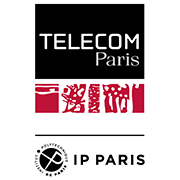</center>

<h1><center><strong><font color="chillipepper">IA 717: Poetry Generation Project</font></strong></center></h1>
<h3><center><font color="blue"><strong>Complete Version</strong></font></center></h3>

<center>
<h3> Project Supervisor <br/> Cyril Chhun</h3>
<email>cyril.chhun@telecom-paris.fr</email>
<br/>
Year 2021-2022
</center>

------------------------

## **Contributions :** 
- Wenjie GuoDuthoit
- Ossee Yiboe


# ⚠ IMPORTANT ⚠

Start by creating your own copy of this notebook: in the top menu, select `File` and then `Save a copy in Drive` (or the equivalent instructions in French). Make sure that it created a copy in a folder named `Colab Notebooks` at the root of your Google Drive.

Also, when you train the model (so, not for now; a reminder will be issued when it is relevant), you should select a GPU runtime for faster training. In the `Runtime` menu, you can do so by selecting `Change runtime type` and choose `GPU`. Google Colab restricts GPU usage so wait until you actually need it.

In [ ]:
import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, inside the `Colab Notebooks` folder, create two empty folders named `dramacode_corpus` and `dramacode_checkpoints`.

In [ ]:
if IN_COLAB:
    ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/'
else:
    ROOT_PATH = './'
DRAMACODE_PATH = ROOT_PATH + "dramacode.github.io/"
NAKED_PATH = DRAMACODE_PATH + "naked/"
CORPUS_PATH = ROOT_PATH + "dramacode_corpus"
CHECKPOINT_PATH = ROOT_PATH + "dramacode_checkpoints"

# Poetry generation

## Introduction

In this project, we will tackle automatic French poetry generation.

Since this task is pretty ambitious, we will need rather complex language models. We will be using recurrent neural networks (RNN), and particularly Long-Short Term Memory (LSTM) cells.

### Task Definition

Let us begin with defining our task more precisely.

In this project, we will focus on verse, specifically [alexandrines](https://www.wikiwand.com/fr/Alexandrin), i.e. twelve-syllable verse.

For example, this famous line from Racine's *Phèdre* is one of them:
> Tout m'afflige et me nuit, et conspire à me nuire.

We will also want these verses to rhyme in pairs, in what we call "flat" rhymes, i.e., of the form AABB(CC...).

> Tout m'afflige et me nuit, et conspire à me nuire.  
> Comme on voit tous ses vœux l’un l’autre se détruire !  
> Vous-même, condamnant vos injustes desseins,  
> Tantôt à vous parer vous excitiez nos mains ;

If you have time and motivation left, you will find at the end of this notebook some additional work tracks.

Of course, you are also free to look for others on your own, should you feel like it!

### On neural networks

#### Basic facts

An in-depth study of neural networks is not the object of this project, but it can be useful to have a rough idea of how they work. We will present them here briefly; the curious reader can consult the sources cited below, refer to the Deep Learning course of the curriculum or search by themslves, on the Internet for example.

The perceptron, also called artificial neuron or formal neuron, tries to reproduce the function of a biological neuron. The objective of a neural network is to reproduce an arbitrarily complex function that associates an input $x$ with an output $y$. For example, we can create neural networks to recognize a dog from a cat: the input is then an image, and the output the word "dog" or "cat".

A layer of a neural network is governed by the following equation:

$$ \hat{y} = f(\mathbf{W} \mathbf{X} + b) $$

where
- $\mathbf{X}$ is the input matrix, usually consisting of several vectors $x_1, \dots, x_m$
- $\hat{y}$ is the output vector
- $\mathbf{W}$ is a matrix of weights (parameters specific to the layer, which can be updated)
- $b$ is a vector of weights called *bias* (also subject to evolution)
- $f$ is a function called *activation function*, generally non-linear like the sigmoid, $\mathrm{ReLU}$ or $\tanh$ functions.

![](https://user.oc-static.com/upload/2018/12/10/15444553183515_neuroneformel-1.png)

The main thing to remember is that the layers of a neural network combine inputs $x_1, \dots, x_m$ by linear (the $\mathbf{W} \mathbf{X} + b$) and non-linear ($f$) operations in the hope of obtaining an output $y$.

In practice, at the initialization of the network, given an input $x$, we usually obtain an output $\hat{y}$ which can be very different from $y$ : the parameters $\mathbf{W}$ and $b$ are not yet appropriate.

We then perform a *training* of the neural network which allows to reduce the distance between $\hat{y}$ and $y$, i.e. to minimize the *loss function* $\mathcal{L}(y, \hat{y}) = \| \hat{y} - y \|^2$. This is usually done by an optimization process such as gradient descent. We will skip the technical details (look at the sources for more information); just remember that by updating the parameters $\mathbf{W}$ and $b$ incrementally, it is possible to improve the performance of the network as it will produce a $\hat{y}$ similar to the desired $y$.

![](https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_01_04-GradientDescent-WHITEBG.png)

By stacking such layers, the network becomes more complex, hence, more elaborate mechanisms can be approximated. However, this usually requires a longer and more data-intensive training. The "*Deep*" in *Deep Learning* reflects the fact that we use multi-layered neural networks.

As an illustration, here is a neural network that learns to separate crosses and circles: the more the training progresses (a step is commonly called *epoch*), the better it works.

![](https://user.oc-static.com/upload/2018/12/12/15446484526497_linearsep_anim.gif)

##### Sources

- [OpenClassrooms - Initiez-vous au Deep Learning](https://openclassrooms.com/fr/courses/5801891-initiez-vous-au-deep-learning)
- [IBM - What are neural networks?](https://www.ibm.com/cloud/learn/neural-networks)

#### Recurrent neural networks

Recurrent neural networks (RNN) are neural networks that are particularly adapted to process sequential data such as time series or text. Indeed, in a text, there are sequential dependencies between words; we cannot write a sentence in any order, in French or English at least.

The difference between RNNs and classical neural networks (usually called *feed-forward neural networks*) is that the former have a "memory" represented by a hidden state that evolves along a "time" axis in any given layer.

![](https://miro.medium.com/max/875/1*AQ52bwW55GsJt6HTxPDuMA.gif)
![](https://miro.medium.com/max/875/1*o-Cq5U8-tfa1_ve2Pf3nfg.gif)
![](https://miro.medium.com/max/875/1*WMnFSJHzOloFlJHU6fVN-g.gif)

There are many ways to implement such a memory; here we will use a type of RNN called LSTM (Long-Short Term Memory), which was the best performing model until the introduction of the *transformer* in 2017 (which *transformer* will not be on the agenda of this project; the curious reader may read the corresponding paper in the sources).

![](https://miro.medium.com/max/875/1*0f8r3Vd-i4ueYND1CUrhMA.png)

The LSTM exhibits several interesting mechanisms; in particular, it has the ability to choose what it wishes to retain or forget in the long term. Refer to the sources for more detail.


##### Sources

- [colah's blog - Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Towards data science - Illustrated Guide to LSTM’s and GRU’s: A step by step explanation](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Distill - Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/)
- [Transformer - Attention Is All You Need](https://arxiv.org/abs/1706.03762)

## Data retrieval

To begin with, we will have to retrieve a set of data relevant to our task.

Since we want to generate alexandrines, we will have to retrieve texts in alexandrines. Luckily, a certain amount of French plays are available on  the [Dramacode](https://dramacode.github.io/) website.

Copy the following code in the empty cell below and run it to mount your Google Drive on this notebook and download the dataset. Once it is done, delete the cell so that you do not run it again by mistake.

```python
!cd /content/drive/MyDrive/"Colab Notebooks" && wget -r -A '*.txt' dramacode.github.io/
```

You should find a `dramacode.github.io` folder in your `Colab Notebooks` folder. We will be using the `txt` files from the `naked` folder.

In [ ]:
# copy the code here

#!cd /content/drive/MyDrive/"Colab Notebooks" && wget -r -A '*.txt' dramacode.github.io/

## Data preprocessing

### Explanations

Now that we have retrieved our data, we will need to preprocess it. There are a few operations we might want to do:
- Filter the files to keep only those which are in alexandrines
- Remove the punctuation or add spaces around
- Put every character to lower case
- Stem the words
- Lemmatize the words
- Remove stop words

Below we will create the functions for each of them. However, you are free to chose which ones you will use; for some, it is difficult to predict if they will improve the results. For others, there are good reasons to choose them, or not. Ideally, you could test every possible combination, but that would take a lot of time.

Just keep in mind that we want to generate **natural** French language.

### Text filtering

We will only do some basic filtering based for instance on the length of the line.
You could open `corneillep_cid.txt` and check the average length of the lines for example.


The function **keep_alexandrines_only** takes an array of lines as input and returns a filtered array containing only the lines that are most likely to be alexandrines. It uses a regular expression to count the number of syllables in each line and removes the ones that don't have exactly 12 syllables.

An alexandrine is a line of poetry that has 12 syllables, with a caesura (a pause) after the sixth syllable.

In [ ]:
import re

def keep_alexandrines_only(lines):
    """
        Given an array of lines, returns the filtered array 
        containing lines which are the most likely to be alexandrines.
    """
    # TODO

    line_final = ""
    for line in lines:
      #line=line.lower().split()
      p = re.compile(r"(([aäâàeêéèëioôöuüûyEAUIOY]{1,3}(?:(?!e)[,\s]*[b-df-hj-np-tv-zB-DF-HJ-NP-TV-Z]))|([aäâàeéèêëioôöuüûyEAUIOY]{1,3}(?![e,\s’.;])))")#([aäâàeêéèëioôöuüûy]{1,3}(?:(?!e)[,\s]*[b-df-hj-np-tv-z]))|([aäâàeéèêëioôöuüûy]{1,3}(?![e,\s’.;]))")
      #syllables=0

      x = p.findall(line)
      syllables=len(x)
      #print(syllables)
      
      if syllables != 12 :
        lines.remove(line)

    return lines


##### **Comments** 

The following code defines a Python function called test_keep_alexandrines_only that tests the keep_alexandrines_only function by printing out the first 50 lines of two different texts and highlighting which lines are alexandrines and which ones are not.

The function first prints the header --- NOT ALEXANDRINES --- to indicate that the following lines are not alexandrines. It then opens a text file from the NAKED_PATH directory called allainval_ecoledesbourgeois.txt and reads the first 50 lines. The keep_alexandrines_only function is called on these lines to extract only the lines that are alexandrines. The resulting lines are printed out, with each line being preceded by the string [ALEXANDRINE] if it is an alexandrine, or [NOT ALEXANDRINE] if it is not.

The function then prints the header --- ALEXANDRINES --- to indicate that the following lines are alexandrines. It opens a different text file from the NAKED_PATH directory called corneillep_cid.txt and reads the first 50 lines. The keep_alexandrines_only function is called again to extract only the lines that are alexandrines, and the resulting lines are printed out in the same way as before.

This testing function is useful to ensure that the keep_alexandrines_only function correctly identifies alexandrines in a given text. By visually inspecting the output, one can verify that the function is correctly identifying the expected lines as alexandrines or not.

In [ ]:
def test_keep_alexandrines_only():
    """ideally, the first section should have much fewer lines than the second part"""
    print("--- NOT ALEXANDRINES ---")
    with open(os.path.join(NAKED_PATH, "allainval_ecoledesbourgeois.txt")) as fin:
        test_lines = keep_alexandrines_only(fin.readlines()[:50])
        
        for line in test_lines:
            
            print(line)
        
    print("\n--- ALEXANDRINES ---")
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = keep_alexandrines_only(fin.readlines()[:50])
        
        for line in test_lines:
            
            print(line)
        

#test_keep_alexandrines_only()  # feel free to comment once you're satisfied

#### Expected result

```
--- NOT ALEXANDRINES ---
Est-ce que tu songes encore à Damis ?
Madame, voilà Monsieur Mathieu qui vient d’entrer.
Vous craignez qu’il ne goûte pas cette alliance ?
Oh ! Mademoiselle n’en tient point.
Il ne donnera jamais son consentement.

--- ALEXANDRINES ---
Entre tous ces amants dont la jeune ferveur
Adore votre fille, et brigue ma faveur,
Don Rodrigue et Don Sanche à l’envi font paraître
Le beau feu qu’en leurs coeurs ses beautés ont fait naître,
Ce n’est pas que Chimène écoute leurs soupirs
Ou d’un regard propice anime leurs désirs,
Au contraire pour tout dedans l’indifférence
Elle n’ôte à pas un, ni donne d’espérance,
Et sans les voir d’un oeil trop sévère, ou trop doux,
C’est de votre seul choix qu’elle attend un époux.
Elle est dans le devoir, tous deux sont dignes d’elle,
Tous deux formés d’un sang, noble, vaillants, fidèle,
Jeunes, mais qui font lire aisément dans leurs yeux
L’éclatante vertu de leurs braves aïeux.
Don Rodrigue sur tout n’a trait en son visage
Qui d’un homme de Cour ne soit la haute image,
Et sort d’une maison si seconde en guerriers,
Qu’ils y prennent naissance au milieu des lauriers,
La valeur de son père, en son temps sans pareille,
Tant qu’a duré sa force a passé pour merveille,
Ses rides sur son front ont gravé ses exploits
Et nous disent encor ce qu’il fut autrefois :
Je me promets du fils ce que j’ai vu du père,
Et ma fille en un mot peut l’aimer et me plaire.
Va l’en entretenir, mais dans cet entretien
Cache mon sentiment et découvre le sien,
Je veux qu’à mon retour nous en parlions ensemble ;
L’heure à présent m’appelle au conseil qui s’assemble,
Le Roi doit à son fils choisir un gouverneur,
Ou plutôt m’élever à ce haut rang d’honneur,
Ce que pour lui mon bras chaque jour exécute,
Me défend de penser qu’aucun me le dispute.
Quelle douce nouvelle à ces jeunes amants !
Et que tout se dispose à leurs contentements !
Et bien, Elvire, enfin, que faut-il que j’espère ?
Que dois-je devenir, et que t’as dit mon père ?
Deux mots dont tous vos sens doivent être charmés,
Il estime Rodrigue autant que vous l’aimez.
L’excès de ce bonheur me met en défiance,
Puisse à de tels discours donner quelque croyance ?
Il passe bien plus outre, il approuve ses feux,
Et vous doit commander de répondre à ses voeux.
```

As you can see, a few lines from the non-verse file sneaked through our rudimentary filter. To improve this, you could for instance compute the percentage of lines kept with respect to the original number of lines: if the ratio is too small, you could choose to keep nothing at all since it is likely that the file is not even in verse.

### Punctuation

#### Explanations

Here we will create functions to either remove punctuation or put spaces around it for better handling later. Let us write both, and you will choose which you want to do. (There is no good or bad answer)

[Relevant documentation](https://docs.python.org/3/library/string.html#string.punctuation).

#### Punctuation spacing

In [ ]:
def space_punctuation(lines):
    """
        given an array of lines, returns the lines with spaced punctuation.
        Caution: inverted commas should ideally not be preceded by spaces.
        For instance, "j'ai faim" should become "j' ai faim".
        It is possible that the `’` symbol is used instead of `'` in the data.
        The str.replace() and str.split() function might help.
    """
    # TODO
    liste1 = [',',';',':','!','?','.','/',"’","<",">"]
    liste_totale = []
    for line in lines :
        for element in liste1:
          if element in line :
            if element == "’":
              line = line.replace(element, element + ' ')
            else :
              line = line.replace(element, ' '+ element + ' ')
        liste_totale.append(line)
    return liste_totale

In [ ]:
def test_space_punctuation():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = space_punctuation(fin.readlines()[2:10])
        for line in test_lines:
            print(line)
#test_space_punctuation()  # feel free to comment once you're satisfied

##### Expected result

```
Entre tous ces amants dont la jeune ferveur
Adore votre fille , et brigue ma faveur ,
Don Rodrigue et Don Sanche à l’ envi font paraître
Le beau feu qu’ en leurs coeurs ses beautés ont fait naître ,
Ce n’ est pas que Chimène écoute leurs soupirs
Ou d’ un regard propice anime leurs désirs ,
Au contraire pour tout dedans l’ indifférence
Elle n’ ôte à pas un , ni donne d’ espérance ,
```


#### Punctuation removal

The **remove_punctuation** function takes an array of lines and returns the lines without punctuation, except for inverted commas which are kept along with a space after them. The function loops over each line in the input array and replaces each punctuation character with an empty string except for inverted commas which are replaced with a space after them. The modified lines are then stored in a new list which is returned at the end.

In [ ]:
def remove_punctuation(lines):
    """
        given an array of lines, returns the lines without punctuation.
        You might want to keep inverted commas and a space after them, though.
        The str.replace() and str.split() function might help.
    """
    # TODO

    liste1 = [',',';',':','!','?','.','/',"<",">","\n"]
    liste_totale = []
    
    for line in lines :
      for element in liste1:
        if element == "’":
              line = line.replace(element, element + ' ')
        else :
              line = line.replace(element,'')
      liste_totale.append(line)
    return liste_totale
      

    pass

In [ ]:
def test_remove_punctuation():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = remove_punctuation(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

#test_remove_punctuation()  # feel free to comment once you're satisfied

##### Expected result

```
Entre tous ces amants dont la jeune ferveur
Adore votre fille et brigue ma faveur
Don Rodrigue et Don Sanche à l’ envi font paraître
Le beau feu qu’ en leurs coeurs ses beautés ont fait naître
Ce n’ est pas que Chimène écoute leurs soupirs
Ou d’ un regard propice anime leurs désirs
Au contraire pour tout dedans l’ indifférence
Elle n’ ôte à pas un ni donne d’ espérance
```

### Lower case

This does not really need testing, since [a function already exists](https://docs.python.org/3/library/stdtypes.html?highlight=lower#str.lower).

### Stemming

You might want to use the NLTK package. [Relevant documentation](https://www.nltk.org/api/nltk.stem.html).

In [ ]:
!python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 504 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


The **stem_lines** function uses remove_punctuation to clean up the input lines, then applies stemming to each word in the lines using the SnowballStemmer from NLTK, with a fallback to Spacy for words that aren't found in the stemmer's dictionary.

It splits each line into words using .split(), applies stemming to each word using the SnowballStemmer (with a fallback to Spacy's lemma_ function), and then joins the stemmed words back together into a single line. The resulting list of stemmed lines is returned by the function.



In [ ]:
from nltk.stem.snowball import SnowballStemmer
import spacy
nlp = spacy.load("fr_core_news_sm")

stemmer = SnowballStemmer(language='french')

def stemming(line):
    doc = nlp(line)
    dic=[stemmer.stem(X.text) for X in doc]
    result=' '.join(dic)
    return result

def stem_lines(lines):
    # TODO
    #lines=remove_punctuation(lines)
    liste_finale=[]
    for line in lines :
      line=stemming(line)
      liste_finale.append(line)
    return liste_finale  

In [ ]:
def test_stem_lines():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = stem_lines(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

#test_stem_lines()  # feel free to comment once you're satisfied

#### Expected result

```
entre tous ce amant dont la jeun ferveur
ador votr fille, et brigu ma faveur,
don rodrigu et don sanch à l’env font paraîtr
le beau feu qu’en leur coeur se beaut ont fait naître,
ce n’est pas que chimen écout leur soupir
ou d’un regard propic anim leur désirs,
au contrair pour tout dedan l’indifférent
elle n’ôt à pas un, ni don d’espérance,
```

### Lemmatization

You might want to use [SpaCy's lemmatizer](https://spacy.io/api/lemmatizer) here.

In [ ]:
!pip install spacy-lefff
import spacy
from spacy_lefff import LefffLemmatizer
from spacy.language import Language

@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 35.2 MB/s 
  Created wheel for spacy-lefff: filename=spacy_lefff-0.4.1-py3-none-any.whl size=2929922 sha256=68457638d079ae30d6f44d0a67a78221e2bfd7403ee1d20f59093eb46dda421a
  Stored in directory: /root/.cache/pip/wheels/c4/54/72/5982052730ae8aea85b95eee7f1252a69413fcf33be05f175d
Successfully built spacy-lefff


In [ ]:
nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('french_lemmatizer', name='lefff')

def lemmatizer(line):

  nlp = spacy.load('fr_core_news_sm')
  nlp.add_pipe('french_lemmatizer', name='lefff')
  doc = nlp(line)

  liste = []
  for d in doc:
    liste.append(d.lemma_)
  result = ' '.join(element for element in liste )
  return result

def lemmatize_lines(lines):
    new_lines=[]
    for line in lines :
      line=lemmatizer(line)
      new_lines.append(line)
    return(new_lines)
    

In [ ]:
def test_lemmatize_lines():
    with open(os.path.join(NAKED_PATH, "corneillep_cid.txt")) as fin:
        test_lines = lemmatize_lines(fin.readlines()[2:10])
        for line in test_lines:
            print(line)

#test_lemmatize_lines()  # feel free to comment once you're satisfied

#### Expected result

```
entre tout ce amant dont le jeune ferveur
Adore votre fille , et brigue mon faveur ,
Don Rodrigue et Don sanche à l’ envi faire paraître
le beau feu qu’ en leur coeur son beauté avoir faire naître ,
ce n’ être pas que chimène écout leur soupir
ou d’ un regard propice anime leur désir ,
au contraire pour tout dedans l’ indifférence
lui n’ ôte à pas un , ni donne d’ espérance ,
```

### Combining the files

We have several preprocessing functions at our disposal. Now, you can choose which ones you want to use to create the final corpus.

Again, remember that we want to generate **natural** French language.

The function **create_corpus** creates a corpus of text by iterating through a directory of text files, selecting only certain files, and then processing each file to extract lines that contain alexandrines. The function then applies several processing steps on these lines, such as space_punctuation, remove_punctuation, and writing them to a text file named corpus.txt. Finally, the function returns the list of processed lines.

In [ ]:
def create_corpus():
    # Folder Path
    path = "/content/drive/MyDrive/Colab Notebooks/dramacode.github.io/naked/" 
      
    # Change the directory
    os.chdir(path)
 
    data = []
    liste = ["corneillep_cid.txt", "corneillep_veuve.txt"]
    
    # iterate through all file
    for file in os.listdir(path) : #NAKED_PATH:
        
        # Check whether file is in text format or not
        if file in liste:
            print(file)
            file_path = file

            with open(os.path.join(NAKED_PATH,file_path )) as fin:
                lines=fin.readlines()[2:150]
                lines1=keep_alexandrines_only(lines)
                lines2=space_punctuation(lines1)
                lines3=remove_punctuation(lines2)
                for line in lines3:
                    print(line)
                    f = open(os.path.join(path, 'corpus.txt'), "w")
                    f.write(line)
                    f.write("\n")
                    f.close()
                    data.append(line)
    return data

You should obtain a file `corpus.txt` which is about 700,000 lines long (but it might be noticeably more or less depending on your filtering choices).

### Splitting the data

Now we will split the data in three datasets: `train`, `valid` and `test`. The `train` dataset will be used to train the model, ie, update its parameters. The `valid` dataset will be used to monitor the evolution of the loss during training, and the `test` dataset will be used to evaluate the model after training. We could do without the `test` dataset here since we will be looking at the generated output ourselves, but this is a common procedure so let us follow it.

For instance, every 100 lines could be split as 80 / 10 / 10 or 90 / 5 / 5.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Folder Path
path = "/content/drive/MyDrive/Colab Notebooks/dramacode_corpus/" #""Enter Folder Path"
  
# Change the directory
os.chdir(path)
data_liste=["train_df" , "val_df" , "test_df"]
file_liste=["train.txt" , "valid.txt" , "test.txt"]


def split_corpus(data_liste,file_liste):
    with open(os.path.join(CORPUS_PATH,"corpus.txt" )) as f:
      corpus = np.random.permutation(f.readlines())
      n = len(corpus)
      n_train = int(n*0.8)
      n_valid = int(n*0.1)
      n_test = int(n*0.1)
      train = pd.DataFrame(corpus[:n_train])
      valid = pd.DataFrame(corpus[n_train:n_train+n_valid])
      test = pd.DataFrame(corpus[n_train+n_valid:n_train+n_valid+n_test])

    with open(os.path.join(CORPUS_PATH,"train3.txt"), 'a') as file: 
      np.savetxt(file, train.values, fmt='%s' , delimiter='', newline='')
    
    with open(os.path.join(CORPUS_PATH,"test3.txt"), 'a') as file:
      np.savetxt(file, test.values, fmt='%s' , delimiter='', newline='')

    with open(os.path.join(CORPUS_PATH,"valid3.txt"), 'a') as file:
      np.savetxt(file, valid.values, fmt='%s', delimiter='', newline='')


In [ ]:
#split_corpus(data_liste, file_liste)
with open(os.path.join(CORPUS_PATH,"valid3.txt" )) as f:
  lines = f.readlines()
  print(len(lines))

47358


## Implementing the model

### Imports

We will be using the [PyTorch](https://pytorch.org/docs/stable/index.html) framework. For a detailed explanation about PyTorch, please refer to their [Learn the Basics tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [ ]:
import os, time, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import pprint  # for pretty printing
pp = pprint.PrettyPrinter()

In [ ]:
# use CUDA if on a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # should be `cpu` for now, we will change runtime later

cuda


### Building the dictionary

First, we need to build a dictionary so that we can pass words as unique identifiers, usually integers, to the model.

In [ ]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}

    def add_word(self, word):
        """ 
        This function should check if the word is in word2idx; if it
        is not, it should add it with the first available index
        """
        if word not in self.word2idx:
          i = self.__len__()
          self.word2idx[word] = i
          self.idx2word[i] = word

        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

### Building the corpus

The **Corpus class** is used to create a text corpus. 

It has an __init__ method that initializes a dictionary, which is a collection of unique words, and three lists of tokenized text data: train, valid, and test. 

The class also has a **tokenize** method that takes a path to a text file as input, reads the text file, and tokenizes the text into a list of integers corresponding to the indices of the words in the dictionary. 

The tokenize method also adds new words to the dictionary if they do not already exist.

In [ ]:
from nltk.tokenize import word_tokenize

class Corpus(object):
    def __init__(self, path):
        # We create an object Dictionary associated to Corpus
        self.dictionary = Dictionary()
        # We go through all files, adding all words to the dictionary
        self.train = self.tokenize(os.path.join(path, 'train3.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid3.txt'))
        self.test = self.tokenize(os.path.join(path, 'test3.txt'))
        self.eos_token = '<eos>'  # end of sentence (line) token
        
    def tokenize(self, path):
        """
            Tokenizes a text file, knowing the dictionary, in order to 
            tranform it into a list of indices.
            The str.split() function might be useful.
        """
        assert os.path.exists(path)
        
        with open(os.path.join(path), 'r') as fin:
          for line in fin.readlines():
            #if line != "\n" :
            words = line.split()
            for word in words:
              self.dictionary.add_word(word)
        self.dictionary.add_word('<eos>')
        
        # Once done, effectively tokenize by adding the tokens to a vector.
        # We want the `ids` vector to be an int64 torch tensor containing all 
        # tokens in the order of the file.
        # Lines should all end with the sos token.
        
        # TODO
        ids_ = []
        with open(os.path.join(path), 'r') as fin:
          for line in fin.readlines():
            #if line != "\n" :
            words = line.split()
            for word in words:
              id = self.dictionary.word2idx[word]
              ids_.append(id)
            id = self.dictionary.word2idx["<eos>"]
            ids_.append(id)
          ids = torch.tensor(ids_, dtype=torch.int64)

        return ids


### Loading the data

In [ ]:
corpus = None  # TODO, create the corpus

path=CORPUS_PATH
corpus = Corpus(path)


In [ ]:
print(corpus.train.shape)
print(corpus.test.shape)
print(corpus.valid.shape)

torch.Size([3583080])
torch.Size([448461])
torch.Size([447787])


### Batching the data

#### `batchify`

Our `corpus.train`, `corpus.valid` and `corpus.test` tensors are flat tensors; they cannot efficiently be processed with a gpu.
We will therefore want to change their shape so that they are more square-like.

With the alphabet being our data, we currently have the sequence:
`[a b c d e f g h i j k l m n o p q r s t u v w x y z]`. We want to reorganize it as independant batches that will be processed independently by the model !

For instance, with the alphabet as the sequence and batch size 4, we'd get the 4 following sequences (represented as columns):
```
┌ a g m s ┐
│ b h n t │
│ c i o u │
│ d j p v │
│ e k q w │
└ f l r x ┘
```
with the last two elements being lost.

Again, these columns are treated as independent by the model, which means that the dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient processing.

❓ **Question**: what do you think of this batching process? For instance, is it adapted to our data? If yes, how so? If not, how could we improve it?

The **batchify** function takes a tensor data and a batch size bsz and returns a new tensor that contains data split into bsz equal-sized chunks. 

The function first calculates the remainder when dividing the length of data by bsz. If this remainder is not zero, the function discards the remaining result number of elements in data. 

The function then calculates the size of each batch (n_size) as len(data)//bsz. 

Finally, the function uses the torch.reshape() function to reshape data to a size of (bsz, n_size), transposes this tensor to obtain a tensor of size (n_size, bsz) and returns this new tensor. 

The tensor is also made contiguous and moved to the appropriate device.

In [ ]:

def batchify(data, bsz):
    """        
        Three steps:
        1. Work out how cleanly we can divide the dataset into bsz parts.
        2. Trim off any extra elements that wouldn't cleanly fit (remainders).
        3. Evenly divide the data across the bsz batches.
        Note: You might need to use `.contiguous()` at the end because PyTorch can be somewhat strict about memory usage.
    """

    # TODO
    result= (len(data)) % bsz
    n_size=len(data)//bsz

    if result != 0 :
      data=data[:-result]
      batch_size = len(data)//bsz
    else : 
      n_size = len(data)//bsz
    data= torch.reshape(data,(bsz,n_size) ).transpose(1,0)

    return data.contiguous().to(device)

In [ ]:
def test_batchify():
    data = torch.tensor(np.arange(26))
    print(batchify(data, 4))

test_batchify()

tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]], device='cuda:0')


##### Expected result


```
tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]])
```

#### `get_batch` function

Now we will build a function `get_batch` which subdivides the source data into chunks of the appropriate length. This function will be used later in the model training and evaluation.

If source is equal to the example output of the batchify function, with
a sequence length (seq_len) of 3, we'd get the following two variables:

```
┌ a g m s ┐ ┌ b h n t ┐
| b h n t | | c i o u │
└ c i o u ┘ └ d j p v ┘
```

The first variable contains the letters input to the network, while the second
contains the one we want the network to predict (b for a, h for g, v for u, etc..)

Note that despite the name of the function, the subdivison of data is not done along the batch dimension (i.e. dimension 1), since that was handled by the `batchify` function. The chunks are along dimension 0, corresponding to the `seq_len` dimension in the LSTM.

In [ ]:
def get_batch(source, i, seq_len):
    """
        Should return (data, target) where data would be the first variable of 
        the example above, and target the second variable.

        - source is the source data;
        - i is the position of the current sequence;
        - seq_len is the sequence length;

        Three steps:
        1. Deal with the possibility that there's not enough data left for a full sequence
        2. Take the input data
        3. Shift by one for the target data
    """

    # TODO
    rest = (len(source.flatten())) % seq_len
    data = source [i : seq_len+i]

    target = source [i+1: seq_len+i+1]
    if len(target) < len(data) :
      data=data[ : len(target)]
      
    return data, target

In [ ]:
def test_get_batch():
    source = torch.tensor(np.arange(26))
    source = batchify(source, 4)
    pp.pprint(get_batch(source, 2, 3))

test_get_batch()

(tensor([[ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22]], device='cuda:0'),
 tensor([[ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]], device='cuda:0'))


##### Expected result

```
(tensor([[ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22]]),
 tensor([[ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]]))
```

#### Batchifying the corpus

In [ ]:
BATCH_SIZE = 128  # you can choose other values
EVAL_BATCH_SIZE = 16  # you can choose other values

train_data = batchify(corpus.train , BATCH_SIZE) #None
val_data = batchify(corpus.valid , EVAL_BATCH_SIZE) 
test_data = batchify(corpus.test , EVAL_BATCH_SIZE) 

In [ ]:
print(corpus.train.shape, train_data.shape)
print(corpus.valid.shape, val_data.shape)
print(corpus.test.shape, test_data.shape)

torch.Size([3583080]) torch.Size([27992, 128])
torch.Size([447787]) torch.Size([27986, 16])
torch.Size([448461]) torch.Size([28028, 16])


##### Expected result (your own corpus lengths and batch sizes may be different)

```
torch.Size([6987667]) torch.Size([54591, 128])
torch.Size([874006]) torch.Size([54625, 16])
torch.Size([872488]) torch.Size([54530, 16])
```

### Building the model

Models are usually implemented as custom nn.Module subclasses.
- We need to redefine the __init__ method, which creates the object.
- We also need to redefine the forward method, which transform the input into outputs.
- We can also add any method that we need: here, in order to initiate weights in the model.

Relevant documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM).

Below is the model we will use; since you are not very familiar with how neural networks work yet, it is already filled and you can use it as a black box. However, you may want to look at it and try to understand how it works. Feel free to discuss about it together; if needed, you can also ask me questions.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.2, initrange=0.1):
        """
            ntoken: length of the dictionary,
            ninp: dimension of the input,
            nhid: dimension of the hidden layers,
            nlayers: number of layers,
            dropout: regularization parameter
            initrange: range for weight initialization
        """
        super().__init__()
        self.ntoken = ntoken
        self.nhid = nhid
        self.nlayers = nlayers
        self.initrange = initrange
        # Create a dropout object to use on layers for regularization
        self.drop = nn.Dropout(dropout)
        # Create an encoder - which is an embedding layer
        self.encoder = nn.Embedding(ntoken, ninp)
        # Create the LSTM layers - find out how to stack them !
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        # Create what we call the decoder: a linear transformation to map the hidden state into scores for all words in the vocabulary
        # (Note that the softmax application function will be applied out of the model)
        self.decoder = nn.Linear(nhid, ntoken)
        
        # Initialize non-recurrent weights 
        self.init_weights()
        
    def init_weights(self):
        # Initialize the encoder and decoder weights with the uniform distribution,
        # between -self.initrange and +self.initrange, and the decoder bias with zeros
        # https://pytorch.org/docs/stable/nn.init.html?highlight=init
        # - the methods uniform_() and zeros_() might help
        # - self.encoder has a .weight attribute
        # - self.decoder has .weight and .bias attributes

        nn.init.uniform_(self.encoder.weight, -self.initrange, self.initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -self.initrange, self.initrange)
        
    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

    def forward(self, input, hidden1):

        # Process the input with the encoder, then dropout
        emb = self.drop(self.encoder(input))

        # Apply the LSTMs
        output, hidden2 = self.rnn(emb, hidden1)
        
        # Decode into scores
        output = self.drop(output)
        decoded = self.decoder(output)

        return decoded, hidden2

❓ **Question**: how does the method `LSTMModel.init_hidden` work?

## **Réponse :**

**La méthode permet en instanciant la classe d'initier un modèle LSTM, à partir de la taille du dictionnaire, des dimensions de l'input, d'une couche cachée, du nombre de couches cachées et la limite pour les valeurs initiales de poids à l'intérieur du modèle** 

## Running the model

In this section, everything is already implemented. However, there are a few questions below that you should try to answer so as to understand what is going on.

### Initializing the parameters

In [ ]:
SEED = 42  # you can choose other values
torch.manual_seed(SEED) # set the random seed manually for reproducibility.

In [ ]:
EMBEDDING_SIZE = 512  # you can choose other values
HIDDEN_SIZE = 1024  # you can choose other values
N_LAYERS = 2  # you can choose other values
DROPOUT = 0.2  # you can choose other values
criterion = nn.CrossEntropyLoss()  # maps the output of a Linear layer to a probability distribution                                   # see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
N_TOKENS = len(corpus.dictionary)  # length of the dictionary
model = LSTMModel(N_TOKENS, EMBEDDING_SIZE, HIDDEN_SIZE, N_LAYERS, DROPOUT).to(device)  # initialize the LSTM model

In [ ]:
# You do not need to thoroughly understand the contents of this cell.
# However, some resources are available in the comments if you are curious.
# The values are not necessarily optimal, by the way;
# you could try to tune them later if you have the time.

LR = 10 # https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10
OPTIMIZER = 'sgd'  # https://ruder.io/optimizing-gradient-descent/
WDECAY = 0  # https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html
CLIP = 0.25  # https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem
if OPTIMIZER == 'sgd':
    optim = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WDECAY)
elif OPTIMIZER == 'adam':
    optim = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)
else:
    optim = None

if OPTIMIZER in ['sgd', 'adam']:
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.7)
else:
    scheduler = None

In [ ]:
# Other global parameters
EPOCHS = 10  # number of rounds of training, you can choose other values
SEQ_LEN = 30  # length of the sequences, you can choose other values
LOG_INTERVAL = 100  # for logging purposes, you can choose other values

### Functions

In [ ]:
def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [ ]:
def train():
    model.train()
    total_loss = 0.
    start_time = time.time()
    hidden = model.init_hidden(BATCH_SIZE)
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, SEQ_LEN)):
        data, targets = get_batch(train_data, i, SEQ_LEN)

        if optim is not None:
            optim.zero_grad()
        hidden = repackage_hidden(hidden)

        output, hidden = model(data, hidden)

        loss = criterion(output.view(-1, N_TOKENS), targets.view(-1))
        
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

        if optim is None:
            for p in model.parameters():
                p.data.add_(p.grad, alpha=-lr)
        else:
            optim.step()

        total_loss += loss.item()

        if batch % LOG_INTERVAL == 0 and batch > 0:
            cur_loss = total_loss / LOG_INTERVAL
            elapsed = time.time() - start_time
            if optim is None:
                print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | '
                        'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // SEQ_LEN, lr,
                    elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss)))
            else:
                print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | '
                        'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // SEQ_LEN, scheduler.get_last_lr()[-1],
                    elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [ ]:
def evaluate(source):
    model.eval()
    total_loss = 0.
    hidden = model.init_hidden(EVAL_BATCH_SIZE)
    with torch.no_grad():
        for i in range(0, source.size(0) - 1, SEQ_LEN):
            data, targets = get_batch(source, i, SEQ_LEN)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            total_loss += len(data) * criterion(output.view(-1, N_TOKENS), targets.view(-1)).item()
    return total_loss / (len(source) - 1)

In [ ]:
liste=[";",".","!",":","?","»"]

def generate(source, n_words, temperature=1, topk=0):
    """
        n_words: number of words to generate
        fout: optional output file
    """
    vocab_to_int = corpus.dictionary.word2idx
    int_to_vocab = corpus.dictionary.idx2word

    model.eval()
    softmax = nn.Softmax(dim=-1)
    source = source.split()
    hidden = model.init_hidden(1)
    for v in hidden:
        v = v.to(device)
    for w in source:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, hidden = model(ix, hidden)
    output = output / temperature
    if topk > 0:
        probas = softmax(torch.topk(softmax(output[0]), topk).values[0]).cpu().detach().numpy()
        indices = torch.topk(softmax(output[0]), topk).indices[0].cpu()
        idx_max = np.random.choice(indices, 1, p=probas)[0]
    else:
        idx_max = int(torch.argmax(softmax(output[0])).cpu().detach().numpy())
    words = []
    words.append(int_to_vocab[idx_max])
    for i in range(1, n_words):
        ix = torch.tensor([[idx_max]]).to(device)
        output, hidden = model(ix, hidden)
        output = output / temperature
        if topk > 0:
            probas = softmax(torch.topk(softmax(output[0]), topk).values[0]).cpu().detach().numpy()
            indices = torch.topk(softmax(output[0]), topk).indices[0].cpu()
            idx_max = np.random.choice(indices, 1, p=probas)[0]
        else:
            idx_max = int(torch.argmax(softmax(output[0])).cpu().detach().numpy())
        words.append(int_to_vocab[idx_max])
    text = " ".join(words)
    for punc in liste :
      if punc in text :
        text = text.replace(punc, "")
    text = text.replace("<eos>", "\n")

    pp.pprint(text)
    #return pp.pprint(text) #words

**Questions** whose answers will help you better understand what is happening:
1. What are `model.train()` and `model.eval()` for?
2. What is the `hidden` variable in the `train()` and `evaluate()` functions?
3. What is `loss.backward()` in `train()` for?
4. What is `optim.step()` for?
5. What is `repackage_hidden()` for?
6. How does the `generate()` function work?

## **Réponses :**

- model.train() permet d'entrainer le modèle sur le corpus train.
- model.eval() permet d'évaluer les performances du modèles sur les données de test.
- La variable hidden dans train() et evaluate() permet d'initialiser un état caché (hidden state) pour effectuer de nouvel prédictions.
- loss.backward() permet de mettre à jour les paramètres qui ont été spécifiées grace à la méthode requires_grad=True, à partir du gradient à chaque epoch de l'entrainement.
- La fonction generate permet pour une séquence de mots donnée, de prédire une distribution de probabilités à partir du modèle pour le dictionnaire. Différentes méthodes ici (top k. et grredy Sampling entre autres) sont ensuite appliquées au résultat pour choisir le mot le plus probable; et ainsi de suite.  

### Training loop

⚠ Now is a good time to switch to a GPU runtime. You might need to run all cells again; make sure that the output of the cell with the `device` variable is `cuda`. ⚠

In [ ]:
MODEL_NAME = 'model4'
SAVE_PATH = os.path.join(CHECKPOINT_PATH, '{}.pt'.format(MODEL_NAME))
LOAD_EXISTING_MODEL = True  # Change to False if you want to start from scratch
                            # ⚠ If False, any existing model with the same name
                            # will be overwritten ⚠

if LOAD_EXISTING_MODEL:
    try:
        with open(SAVE_PATH, 'rb') as f:
            model = torch.load(f)
            # after load the rnn params are not a continuous chunk of memory
            # this makes them a continuous chunk, and will speed up forward pass
            model.rnn.flatten_parameters()
        print("Successfully loaded model from {}".format(SAVE_PATH))
    except:
        pass
    
best_val_loss = None

Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/dramacode_checkpoints/model4.pt


In [ ]:
import warnings

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 27 07:40:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |   2294MiB / 15109MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Load the best saved model.
with open(SAVE_PATH, 'rb') as f:
    model = torch.load(f)
    # after load the rnn params are not a continuous chunk of memory
    # this makes them a continuous chunk, and will speed up forward pass
    model.rnn.flatten_parameters()

In [ ]:
# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  4.71 | test ppl   110.99


In [ ]:
# Generate some text with Greedy Search

# TODO

sources = [" Il devait "]#,"Je suis" , "Il ne sera"," Jamais au grand jamais"]

for source in sources :
  print(source)
  generate(source, 30, temperature=1, topk=0)  

 Il devait 
('vous faire un peu de puissance \n'
 ' Et que de mon amour je ne puis vous défendre \n'
 ' Et que de mon amour je ne puis vous défendre \n'
 ' Et')


In [ ]:
# Generate some text with Top K Search

sources = ["Dans ces aimables","Je suis" , "Il ne sera"]

for source in sources :
  print(source)
  generate(source, 80, temperature=1, topk=3)
  print("\n")

Dans ces aimables
('\n'
 ' Et que de ce grand coeur vous pouvez faire entendre  \n'
 ' Je le sais mais pour moi de ce que je vous dois    \n'
 ' Je vous ai dit Seigneur et je vous en promets \n'
 ' Que vous ne vous trompez de me voir davantage \n'
 ' Je le vois mais pour moi de vous en faire grâce \n'
 ' Je vous laisse en effet ce qui me doit entendre  \n'
 ' Que je suis malheureux et je')


Je suis
('trop à vous de vous voir en ce lieu  \n'
 ' Que je suis malheureux  Et que vous ne voulez \n'
 ' Que je suis en ces mots la gloire de la guerre \n'
 ' Et que pour vous punir il est temps de la voir \n'
 ' Et si pour vous servir je ne puis vous défendre \n'
 ' Que vous ne me devez pas vous en dire assez \n'
 ' Je le veux bien encor pour le moins je le veux \n')


Il ne sera
('point de plus de puissance    \n'
 ' Que de vous voir encor le soin de votre époux    Et que vous me verrez je '
 'vous en fais la cause  \n'
 ' Et si je puis à moi le sort qui me dévore  \n'
 " Et si vous ne pensez à

#### **Beam Search :**

The "beam_search_decoder" function performs beam search decoding on a given input sequence using a pre-trained language model.

The function takes the following arguments:

-- **source**: A string representing the input sequence.

-- **k**: An integer representing the beam width, i.e., the number of candidates to consider at each decoding step.

-- **n_words**: An integer representing the maximum length of the output sequence.
-- **temperature** : A float representing the softmax temperature used to control the randomness of the output.

- The function first initializes the vocabulary of the language model using a dictionary that maps each word to an integer index. 
- It then converts the input sequence into a list of words and feeds it into the language model to obtain the hidden states of the model.

- The function then uses a beam search algorithm to generate the output sequence : 
  - the algorithm maintains a set of candidate sequences and at each decoding step, 
  - it generates k new candidates by extending each of the current candidates with all possible next words according to the language model probabilities. 
  - The candidates are then ranked according to a score that combines the language model probabilities and the length of the sequence, and 
  - the k candidates with the highest score are selected to form the new set of candidate sequences.

The beam search decoding continues until the maximum length n_words is reached, or until all candidate sequences end with a special end-of-sentence token.

Finally, the function selects the highest-scoring candidate sequence and converts it back into a string representation. It removes any punctuation characters from the output sequence and replaces any remaining end-of-sentence tokens with a newline character before printing the output using the pprint function.


In [ ]:
## Generate with Beam search
liste=[";",".","!",":","?","»"]

def beam_search_decoder(source, k, n_words, temperature=5):

  vocab_to_int = corpus.dictionary.word2idx
  int_to_vocab = corpus.dictionary.idx2word
  words = []

  model.eval()
  softmax = nn.Softmax(dim=-1)
  source = source.split()
  hidden = model.init_hidden(1)
  for v in hidden:
      v = v.to(device)
  for w in source:
      ix = torch.tensor([[vocab_to_int[w]]]).to(device)
      output, hidden = model(ix, hidden)
  output = output / temperature

  row  = softmax(output[0]).cpu().detach().numpy()[0]
  l = list()
  
  sequences = [[l, 0.]]
  all_candidates = list()
  n = 0

  for i in range(len(sequences)):
    seq, score = sequences[i]
    for j in range(len(row)) :
      candidate = [seq + [j], (score - np.log(row[j]))/len(int_to_vocab)] 
      all_candidates.append(candidate)
  # order all candidates by score

  ordered = sorted(all_candidates, key=lambda tup:tup[1])
  sequences = ordered[:k]

# Changement commence ici !!!
  for sequence in sequences:
        indice = sequence[0]
        ix = torch.tensor([[indice]]).to(device)
        output, hidden = model(ix, hidden) 
        output = output / temperature
        row = softmax(output[0]).cpu().detach().numpy()[0]
        l = list()

        all_candidates = list()

        # expand each current candidate
        for j in range(len(row)) :
            if j not in index :
              candidate = [seq + [j], (score - np.log(row[j]))/len(int_to_vocab)] 
              all_candidates.append(candidate)
        # order all candidates by score

        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]
        n += 1
  
  # loop through potential candidates
  
  while n < n_words :
    for sequence in sequences:
        indice = sequence[0]
        ix = torch.tensor([[indice[-1]]]).to(device)
        output, hidden = model(ix, hidden) 
        output = output / temperature
        row = softmax(output[0]).cpu().detach().numpy()[0]
        l = list()

        all_candidates = list()

        # expand each current candidate
        for j in range(len(row)) :
            if j not in index :
              candidate = [seq + [j], (score - np.log(row[j]))/len(int_to_vocab)] 
              all_candidates.append(candidate)
        # order all candidates by score

        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]
        n += 1

  index = sequences[0][0]       

  for element in index :
      w = int_to_vocab[element]
      words.append(w)
  text = source
  text = " ".join(words)
  for punc in liste :
    if punc in text :
      text = text.replace(punc, "")
  text = text.replace("<eos>", "\n")

  pp.pprint(text)


#### **Examples of generation with 30 words**

In [ ]:
# generate_beam("Je suis", 10, temperature=1, n_beam=3)

sources = ["Je suis" ]

for source in sources :
  print(source)
  beam_search_decoder(source, 5, 30, temperature = 1)
print("\n")

for source in sources :
  print(source)
  beam_search_decoder(source, 3, 30, temperature = 1)
print("\n")

for source in sources :
  print(source)
  beam_search_decoder(source, 50, 30, temperature = 1)
print("\n")

Je suis
('bien de vous voir que je ne puis croire \n'
 " Et si ce n'est pas là le plus grand des humains    Je suis trop heureux et "
 'mon')


Je suis
('bien de vous voir que je ne puis croire \n'
 " Et si ce n'est pas là le plus grand des humains    Je suis trop heureux et "
 'mon')


Je suis
('bien de vous voir que je ne puis croire \n'
 " Et si ce n'est pas là le plus grand des humains    Je suis trop heureux et "
 'mon')




#### **Top P Sampling with Low threshold :**

The top_p_decoder function generates text using the top-p sampling strategy with a low probability threshold value.

The function takes the following arguments:

-- **source**: A string representing the input sequence.

-- **s**: A float representing the probability threshold value for the top-p sampling strategy.

-- **n_words**: An integer representing the maximum length of the output sequence.

-- **temperature**: A float representing the softmax temperature used to control the randomness of the output.

- The function first initializes the vocabulary of the language model using a dictionary that maps each word to an integer index. 

- It then converts the input sequence into a list of words and feeds it into the language model to obtain the hidden states of the model.

The function then performs top-p sampling to generate the output sequence. 

- At each decoding step, the function :
  - computes the softmax probabilities of the next words according to the language model, 
  - sorts the probabilities in descending order, and 
  - selects the subset of words that have a cumulative probability lower than the probability threshold value s. 

- The function then randomly samples one of the remaining words from this subset, and uses it as the next word in the output sequence.

The top-p sampling continues until the maximum length n_words is reached, or until a special end-of-sentence token is generated.

Finally, the function selects the generated sequence and converts it back into a string representation. It removes any punctuation characters from the output sequence and replaces any remaining end-of-sentence tokens with a newline character before printing the output using the pprint function.

In [ ]:
## Generate with Top_p with low threshold value
liste = [";",".","!",":","?","»"]


def top_p_decoder(source, s, n_words, temperature=1.):

  # sampler = NucleusSampler(0.95, TemperatureSampler(temperature)) #NucleusSampler(s,Sampler)

  vocab_to_int = corpus.dictionary.word2idx
  int_to_vocab = corpus.dictionary.idx2word
  words=[]

  model.eval()
  softmax = nn.Softmax(dim=-1)
  source = source.split()
  hidden = model.init_hidden(1)
  for v in hidden:
      v = v.to(device)
  for w in source :
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, hidden = model(ix, hidden) 
    output = output / temperature

  row = softmax(output[0])[0].clone().detach()
  
  indices = torch.argsort(row, dim=0, descending=True)
  tri =[]
  for indice in indices :
    tri.append(float(row[indice].cpu().detach()))
  cum_probs = torch.cumsum(torch.tensor(tri).to(device), dim=-1)
  l_tmp = torch.vstack([indices,cum_probs])
  
  l = torch.tensor([cum_prob <= s for cum_prob in cum_probs])
  n_idx = torch.sum(l) + 1

  index_tmp = []

  for e in (l_tmp[0][:n_idx]) :
    index_tmp.append(int(e))
  ix = np.random.choice(index_tmp)
  
  index = []
  index.append(ix)
  n = len(index)

  while n < n_words :

    output, hidden = model(torch.tensor([[ix]]).to(device), hidden) 
    output = output / temperature
    row = softmax(output[0])[0].clone().detach()

    ## Récupération des indices de probas les plus élevés

    indices = torch.argsort(row, dim=0, descending=True).to(device)
    
    tri =[]

    for indice in indices :
      tri.append(float(row[indice].cpu().detach()))
    cum_probs = torch.cumsum(torch.tensor(tri).to(device), dim=-1)
    l_tmp = torch.vstack([indices,cum_probs])
    
    l = torch.tensor([cum_prob <= s for cum_prob in cum_probs])
    n_idx = torch.sum(l) + 1

    index_tmp = []

    for e in (l_tmp[0][:n_idx]) :
      index_tmp.append(int(e))
    ix = np.random.choice(index_tmp)
    index.append(ix)
    ix = torch.tensor([[ix]]).to(device)
    n = len(index)      

  for element in index :
      w = int_to_vocab[element]
      words.append(w)
      
  text = source
  text = " ".join(words)
  for punc in liste :
    if punc in text :
      text = text.replace(punc, "")
  text = text.replace("<eos>", "\n")

  pp.pprint(text)

#### **Examples of generation of 20 words and 0.05 of threshold:**

In [ ]:
source = 'Je'
'''(suis bien de vous voir que je vous le jure \n'
 ' Et que de mon amour je ne puis vous')'''

liste_temperature =[0.1 , 0.5 , 1. , 2 , 5]

#for v in liste_temperature :
top_p_decoder(source, 0.05, 20, temperature=1.)

('ne puis vous voir que pour vous en instruire \n'
 ' Et que de mon amour je ne puis vous défendre')


#### **Top P Sampling with High threshold :**

The top_p_decoder_desc function generates text using the top-p sampling strategy with a high probability threshold value.

The function takes the following arguments:

-- **source**: A string representing the input sequence.

-- **s**: A float representing the probability threshold value for the top-p sampling strategy.

-- **n_words** : An integer representing the maximum length of the output sequence.

-- **temperature**: A float representing the softmax temperature used to control the randomness of the output.

- The function first initializes the vocabulary of the language model using a dictionary that maps each word to an integer index. 

- It then converts the input sequence into a list of words and feeds it into the language model to obtain the hidden states of the model.

The function then performs top-p sampling to generate the output sequence. 

- At each decoding step, the function : 
  - computes the softmax probabilities of the next words according to the language model, 
  - sorts the probabilities in ascending order, and 
  - selects the subset of words that have a cumulative probability greater than or equal to the probability threshold value s. 
  - The function then randomly samples one of the remaining words from this subset, and 
  - uses it as the next word in the output sequence.

The top-p sampling continues until the maximum length n_words is reached, or until a special end-of-sentence token is generated.

Finally, the function selects the generated sequence and converts it back into a string representation. It removes any punctuation characters from the output sequence and replaces any remaining end-of-sentence tokens with a newline character before printing the output using the pprint function.

In [ ]:
## Generate with Top_p with high threshold value

liste = [";",".","!",":","?","»"]

def top_p_decoder_desc(source, s, n_words, temperature=1.):

  vocab_to_int = corpus.dictionary.word2idx
  int_to_vocab = corpus.dictionary.idx2word
  words=[]

  model.eval()
  softmax = nn.Softmax(dim=-1)
  source = source.split()
  hidden = model.init_hidden(1)
  for v in hidden:
      v = v.to(device)
  for w in source :
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, hidden = model(ix, hidden) 
    output = output / temperature

  row = softmax(output[0])[0].clone().detach()
  
  indices = torch.argsort(row, dim=0, descending=False) 
  tri =[]

  for indice in indices :
    tri.append(float(row[indice].cpu().detach()))    
  cum_probs = torch.cumsum(torch.tensor(tri).to(device), dim=-1)
  l_tmp = torch.vstack([indices,cum_probs])
  l = torch.tensor([cum_prob >= s for cum_prob in cum_probs])
  n_idx = torch.sum(l) -1

  index_tmp = []
  x = len(l_tmp[0]) - n_idx - 1
  for e in (l_tmp[0][x:]) :
    index_tmp.append(int(e))

  ix = np.random.choice(index_tmp)
  index = []
  index.append(ix)
  n = len(index)

  while n < n_words :
    temperature = 0.5
    output, hidden = model(torch.tensor([[ix]]).to(device), hidden)
    row = softmax(output[0])[0].clone().detach()

    indices = torch.argsort(row, dim=0, descending=False).to(device)
    tri = []

    for indice in indices :
      tri.append(float(row[indice].cpu().detach()))
    cum_probs = torch.cumsum(torch.tensor(tri).to(device), dim=-1)
    l_tmp = torch.vstack([indices,cum_probs])

    l = torch.tensor([cum_prob >= s for cum_prob in cum_probs])
    n_idx = torch.sum(l) - 1

    index_tmp = []
    x = len(l_tmp[0]) - n_idx -1
    for e in (l_tmp[0][x:]) :
      index_tmp.append(int(e))

    ix= np.random.choice(index_tmp)

    index.append(ix)
    n = len(index)      

  for element in index :
      w = int_to_vocab[element]
      words.append(w)
  text=source
  text = " ".join(words)
  for punc in liste :
    if punc in text :
      text = text.replace(punc, "")
  text = text.replace("<eos>", "\n")

  pp.pprint(text)

#### **Examples of generation of 20 words and 0.90 of threshold:**

In [ ]:
source = 'Je'
'''(suis bien de vous voir que je vous le jure \n'
 ' Et que de mon amour je ne puis vous')'''

liste_temperature =[ 1. ]

for v in liste_temperature :
  top_p_decoder_desc(source, 0.90, 20, temperature=v)

('veux vous dire et je ne puis comprendre \n'
 ' Et je ne puis souffrir que de vous en instruire \n')


#### **Combining Top P Sampling with High threshold and Top k approaches :**


The top_p_k_decoder function generates text using a combination of top-p and top-k sampling strategies.

The function takes the following arguments:

-- **source**: A string representing the input sequence.

-- **s**: A float representing the probability threshold value for the top-p sampling strategy.

-- **n_words**: An integer representing the maximum length of the output sequence.

-- **temperature**: A float representing the softmax temperature used to control the randomness of the output.

- The function first initializes the vocabulary of the language model using a dictionary that maps each word to an integer index.

- It then converts the input sequence into a list of words and feeds it into the language model to obtain the hidden states of the model.

The function then performs top-p and top-k sampling to generate the output sequence. 

- At each decoding step, the function : 
  - computes the softmax probabilities of the next words according to the language model, 
  - selects the top-k words with the highest probabilities, and 
  - computes the subset of words that have a cumulative probability greater than or equal to the probability threshold value **s**. 
  - The function then randomly samples one of the remaining words from this subset, and 
  - uses it as the next word in the output sequence.

The top-p and top-k sampling continue until the maximum length n_words is reached, or until a special end-of-sentence token is generated.

Finally, the function selects the generated sequence and converts it back into a string representation. It removes any punctuation characters from the output sequence and replaces any remaining end-of-sentence tokens with a newline character before printing the output using the pprint function.

In [ ]:
def top_p_k_decoder(source, s, n_words, temperature=1.):

  vocab_to_int = corpus.dictionary.word2idx
  int_to_vocab = corpus.dictionary.idx2word
  words=[]

  model.eval()
  softmax = nn.Softmax(dim=-1)
  source = source.split()
  hidden = model.init_hidden(1)
  for v in hidden:
      v = v.to(device)
  for w in source :
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, hidden = model(ix, hidden) 
    output = output / temperature

  row = softmax(output[0])[0].clone().detach()
  
  indices = torch.argsort(row, dim=0, descending=False) 
  tri =[]

  for indice in indices :
    tri.append(float(row[indice].cpu().detach()))
  cum_probs = torch.cumsum(torch.tensor(tri).to(device), dim=-1)
  l_tmp = torch.vstack([indices,cum_probs])
  l = torch.tensor([cum_prob >= s for cum_prob in cum_probs])

  topk = torch.sum(l)
  probas = softmax(torch.topk(softmax(output[0]), topk).values[0]).cpu().detach().numpy()
  indices = torch.topk(softmax(output[0]), topk).indices[0].cpu()
  ix = np.random.choice(indices, 1, p=probas)[0]

  index = []
  index.append(ix)
  n = len(index)

  while n < n_words :
    output, hidden = model(torch.tensor([[ix]]).to(device), hidden)
    row = softmax(output[0])[0].clone().detach()

    indices = torch.argsort(row, dim=0, descending=False).to(device)
    tri =[]

    for indice in indices :
      tri.append(float(row[indice].cpu().detach()))
    cum_probs = torch.cumsum(torch.tensor(tri).to(device), dim=-1)
    l_tmp = torch.vstack([indices,cum_probs])

    l = torch.tensor([cum_prob >= s for cum_prob in cum_probs])

    topk = torch.sum(l)
    probas = softmax(torch.topk(softmax(output[0]), topk).values[0]).cpu().detach().numpy()
    indices = torch.topk(softmax(output[0]), topk).indices[0].cpu()
    ix = np.random.choice(indices, 1, p=probas)[0]

    index.append(ix)
    n = len(index)      

  for element in index :
      w = int_to_vocab[element]
      words.append(w)
  text=source
  text = " ".join(words)
  for punc in liste :
    if punc in text :
      text = text.replace(punc, "")
  text = text.replace("<eos>", "\n")

  pp.pprint(text)


#### **Examples of generation of 50 words and 0.90 of threshold:**

In [ ]:
source ='Je'
top_p_k_decoder(source, 0.90, 50, temperature=1.)

('ne puis me résoudre à ce que je puis \n'
 ' Je ne puis plus souffrir que de vous en donner \n'
 ' Et je ne puis souffrir que de votre personne \n'
 ' Et que pour vous servir il faut que je vous quitte \n'
 ' Et que de ce grand jour je')
